[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hb_W3pPkB8Fs_n9c4Z6zyuL_yQkNHmOH?usp=sharing)


# I. Setup

In [1]:
!nvidia-smi

Thu Dec 16 21:25:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.09       Driver Version: 497.09       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8    N/A /  N/A |    754MiB /  4096MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence
import cv2
import tensorflow as tf 
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.cluster import KMeans
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import * 
import glob2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt 
from tensorflow.keras.metrics import MeanIoU

# II. Defind function and Class

In [2]:
def cvtColor(x):
    x[x < 255] = 0
    return x

In [3]:
def func(img):
    d = list(map(lambda x: cvtColor(x), img.reshape(-1,3)))
    return np.array(d).reshape(*img.shape[:-1], 3)

In [4]:
class DataGenerator(Sequence):
    def __init__(self, all_filenames, input_size = (256, 256), batch_size = 32, shuffle = True, seed = 123, encode: dict = None, color_mode = 'hsv', function = None) -> None:
        super(DataGenerator, self).__init__()
        assert encode != None,  'Not empty !'
        assert color_mode == 'hsv' or color_mode == 'rgb' or color_mode == 'gray'
        self.all_filenames = all_filenames
        self.input_size = input_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.color_mode = color_mode
        self.encode = encode
        self.function = function
        np.random.seed(seed)
        self.on_epoch_end()
    def processing(self, mask):
        d = list(map(lambda x: self.encode[tuple(x)], mask.reshape(-1,3)))
        return np.array(d).reshape(*self.input_size, 1)
    def __len__(self):
        return int(np.floor(len(self.all_filenames) / self.batch_size))
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        all_filenames_temp = [self.all_filenames[k] for k in indexes]
        X, Y = self.__data_generation(all_filenames_temp)
        return X, Y
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.all_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __data_generation(self, all_filenames_temp):
        batch = len(all_filenames_temp)
        if self.color_mode == 'gray':
            X = np.empty(shape=(batch, *self.input_size, 1))
        else:
            X = np.empty(shape=(batch, *self.input_size,3))
        Y = np.empty(shape=(batch, *self.input_size, 1))
        for i, (fn, label_fn) in enumerate(all_filenames_temp):
            # img
            img = cv2.imread(fn)
            if self.color_mode == 'hsv':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif self.color_mode == 'rgb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif self.color_mode == 'gray':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = tf.expand_dims(img, axis = 2)
            img = tf.image.resize(img, self.input_size, method = 'nearest')
            img = tf.cast(img, tf.float32)
            img /= 255.
            
            #mask
            mask = cv2.imread(label_fn, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask = tf.image.resize(mask, self.input_size, method= 'nearest')
            mask = np.array(mask)
            if self.function:
                mask = self.function(mask)
            mask = self.processing(mask)
            mask = tf.cast(mask, tf.float32)
            X[i,] = img
            Y[i,] = mask
        return X, Y

In [5]:
def encode_label(mask):
    # input (batch, rows, cols, channels)
    label = [] 
    for i in mask.reshape(-1,3):
        label.append(tuple(i))
    label = set(label)
    encoder = dict((j,i) for i,j in enumerate(label)) # key is tuple 
    with open('label.pickle', 'wb') as handel:
        pickle.dump(encoder, handel, protocol= pickle.HIGHEST_PROTOCOL)
    return encoder
def decode_label(predict, label):
    predict = np.argmax(predict, axis = 3) 
    d = list(map( lambda x: label[int(x)], predict.reshape(-1,1)))
    img =  np.array(d).reshape(*predict.shape, 3)
#     b,g,r = cv2.split(img)
#     return cv2.merge((r,g,b))
    return img
def DataLoader(all_train_filename, all_mask,  all_valid_filename = None, input_size = (256,256), batch_size = 4, shuffle = True, seed = 123, color_mode = 'hsv', function = None) -> None:
    mask_folder = sklearn.utils.shuffle(all_mask, random_state = 47)[:16]
    mask = [tf.image.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), input_size, method = 'nearest') for img in mask_folder ]
    mask = np.array(mask)
    if function:
        mask = function(mask)
    encode = encode_label(mask)
    train = DataGenerator(all_train_filename, input_size, batch_size , shuffle, seed, encode, color_mode, function)
    if all_valid_filename == None: 
        return train, None
    else:
        valid = DataGenerator(all_valid_filename, input_size, batch_size, shuffle, seed, encode, color_mode, function)
        return train, valid

In [6]:
def down_block(x, filters, use_maxpool = True):
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    if use_maxpool == True:
        return  MaxPooling2D(strides= (2,2))(x), x
    else:
        return x
def up_block(x,y, filters):
    x = UpSampling2D()(x)
    x = Concatenate(axis = 3)([x,y])
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters, 3, padding= 'same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    return x
    
def Unet(input_size = (256, 256, 3), *, classes, dropout):
    filter = [64,128,256,512, 1024]
    # encode
    input = Input(shape = input_size)
    x, temp1 = down_block(input, filter[0])
    x, temp2 = down_block(x, filter[1])
    x, temp3 = down_block(x, filter[2])
    x, temp4 = down_block(x, filter[3])
    x = down_block(x, filter[4], use_maxpool= False)
    # decode 
    x = up_block(x, temp4, filter[3])
    x = up_block(x, temp3, filter[2])
    x = up_block(x, temp2, filter[1])
    x = up_block(x, temp1, filter[0])
    x = Dropout(dropout)(x)
    output = Conv2D(classes, 1, activation= 'softmax')(x)
    model = models.Model(input, output, name = 'unet')
    model.summary()
    return model


In [10]:
from tensorflow.keras.metrics import MeanIoU
import numpy as np
class m_iou():
    def __init__(self, classes: int) -> None:
        self.classes = classes
    def mean_iou(self,y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)
        return miou_keras.result().numpy()
    def miou_class(self, y_true, y_pred):
        y_pred = np.argmax(y_pred, axis = 3)
        miou_keras = MeanIoU(num_classes= self.classes)
        miou_keras.update_state(y_true, y_pred)        
        values = np.array(miou_keras.get_weights()).reshape(self.classes, self.classes)
        for i in  range(self.classes):
            class_iou = values[i,i] / (sum(values[i,:]) + sum(values[:,i]) - values[i,i])
            print(f'IoU for class{str(i + 1)} is: {class_iou}')

In [16]:
import matplotlib.pyplot as plt 
def show_history(history, validation : bool = False):
    if validation:
        # Loss
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['loss'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_loss'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Loss')
        axes.legend()
        # Acc
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['acc'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_acc'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('Acc')
        axes.legend()
        # Mean Iou
        fig, axes = plt.subplots(figsize= (20,5))
        # Train
        axes.plot(history.epoch, history.history['mean_iou'], color= 'r',  label = 'Train')
        axes.plot(history.epoch, history.history['val_mean_iou'], color = 'b', label = 'Val')
        axes.set_xlabel('Epoch')
        axes.set_ylabel('MeanIoU')
        axes.legend()
    else:
        fig, axes = plt.subplots(1,4, figsize= (20,5))
        # loss
        axes[0].plot(history.epoch, history.history['loss'])
        axes[0].set_title('Train')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        # Acc
        axes[1].plot(history.epoch, history.history['acc'])
        axes[1].set_title('Train')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Acc')
        # Mean Iou
        axes[2].plot(history.epoch, history.history['mean_iou'])
        axes[2].set_title('Train')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('MeanIoU')

In [17]:
def predict(model, image_test, label, color_mode, size):
    image = cv2.imread(image_test)
    if color_mode == 'hsv':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_mode == 'rgb':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif color_mode == 'gray':
        image_cvt = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_cvt = tf.expand_dims(image_cvt, axis = 2)
    image_cvt = tf.image.resize(image_cvt, size, method= 'nearest')
    image_cvt = tf.cast(image_cvt, tf.float32) 
    image_norm = image_cvt / 255.
    image_norm = tf.expand_dims(image_norm, axis= 0)
    new_image = model(image_norm)
    image_decode = decode_label(new_image, label)
    predict_img = tf.cast(tf.image.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), size, method = 'nearest'), tf.float32) * 0.7 + image_decode * 0.3
    return np.floor(predict_img)[0].astype('int'), new_image

In [18]:
def show_example(image, mask, model, label, inp_size, color_mode, function):
    img = cv2.imread(image)
    img = tf.image.resize(img, inp_size, method ='nearest')
    pred, _pred= predict(model, image, label, color_mode, inp_size)
    if mask != None:
        msk= cv2.imread(mask)
        msk= tf.image.resize(msk, inp_size, method = 'nearest')
        if function:
            msk = tf.convert_to_tensor(function(msk.numpy()))
        m.miou_class(train_data.processing(msk.numpy()), _pred)
        ground_truth = np.floor(img.numpy() * 0.7 + msk.numpy() * 0.3).astype('int')
        fig, axes = plt.subplots(1,3, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Ground truth')
        axes[1].imshow(ground_truth)
        axes[2].set_title('Prediction')
        axes[2].imshow(pred)

    else:
        fig, axes = plt.subplots(1,2, figsize = (12,3))
        axes[0].imshow(img)
        axes[0].set_title('Original Image')
        axes[1].set_title('Prediction')
        axes[1].imshow(pred)
    

# III. Prepare data to train

In [8]:
images = glob2.glob('frames/*.jpg')
masks = glob2.glob('masks/*.jpg')
data = list(zip(images, masks))
data = shuffle(data, random_state= 42)
split = int(0.9 * len(data))
all_train_filenames = data[:split]
all_valid_filenames = data[split:]

In [9]:
train_data, valid_data = DataLoader(all_train_filenames, masks, all_valid_filenames, (128, 128), 8, True, 47, 'gray', function= func)
inp_size = (128, 128, 1)
unet = Unet(inp_size, classes= 2, dropout= 0.3)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

In [11]:
m = m_iou(2)

In [12]:
checkpoint = ModelCheckpoint('unet.h5', monitor= 'val_mean_iou', save_best_only= True, verbose= 1, mode = 'max')
lr_R = ReduceLROnPlateau(monitor= 'loss', patience= 4, verbose= 1, factor= 0.3, min_lr= 0.00001)

# IV. Train

In [13]:
unet.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics= [m.mean_iou, 'acc'], run_eagerly= True)
history = unet.fit(train_data, validation_data= valid_data, epochs= 70, verbose= 1, callbacks = [checkpoint, lr_R])

Epoch 1/70
307/307 [==============================] - ETA: 0s - loss: 0.0839 - mean_iou: 0.4961 - acc: 0.9775
Epoch 00001: val_mean_iou improved from -inf to 0.49275, saving model to unet.h5
307/307 [==============================] - 327s 1s/step - loss: 0.0839 - mean_iou: 0.4961 - acc: 0.9775 - val_loss: 0.0852 - val_mean_iou: 0.4928 - val_acc: 0.9855 - lr: 0.0100
Epoch 2/70
307/307 [==============================] - ETA: 0s - loss: 0.0438 - mean_iou: 0.5703 - acc: 0.9860
Epoch 00002: val_mean_iou improved from 0.49275 to 0.56183, saving model to unet.h5
307/307 [==============================] - 320s 1s/step - loss: 0.0438 - mean_iou: 0.5703 - acc: 0.9860 - val_loss: 0.0507 - val_mean_iou: 0.5618 - val_acc: 0.9843 - lr: 0.0100
Epoch 3/70
307/307 [==============================] - ETA: 0s - loss: 0.0367 - mean_iou: 0.6455 - acc: 0.9881
Epoch 00003: val_mean_iou improved from 0.56183 to 0.67205, saving model to unet.h5
307/307 [==============================] - 315s 1s/step - loss: 0.0

307/307 [==============================] - ETA: 0s - loss: 0.0087 - mean_iou: 0.8841 - acc: 0.9964
Epoch 00047: val_mean_iou improved from 0.86275 to 0.86283, saving model to unet.h5
307/307 [==============================] - 371s 1s/step - loss: 0.0087 - mean_iou: 0.8841 - acc: 0.9964 - val_loss: 0.0117 - val_mean_iou: 0.8628 - val_acc: 0.9956 - lr: 0.0030
Epoch 48/70
307/307 [==============================] - ETA: 0s - loss: 0.0087 - mean_iou: 0.8846 - acc: 0.9964
Epoch 00048: val_mean_iou improved from 0.86283 to 0.86418, saving model to unet.h5
307/307 [==============================] - 346s 1s/step - loss: 0.0087 - mean_iou: 0.8846 - acc: 0.9964 - val_loss: 0.0119 - val_mean_iou: 0.8642 - val_acc: 0.9956 - lr: 0.0030
Epoch 49/70
307/307 [==============================] - ETA: 0s - loss: 0.0085 - mean_iou: 0.8863 - acc: 0.9965
Epoch 00049: val_mean_iou did not improve from 0.86418
307/307 [==============================] - 321s 1s/step - loss: 0.0085 - mean_iou: 0.8863 - acc: 0.996

# V. Predict 

In [14]:
with open('label.pickle', 'rb') as handel:
    k = pickle.load(handel)

In [15]:
encode = dict((j,list(i)) for i,j in k.items())

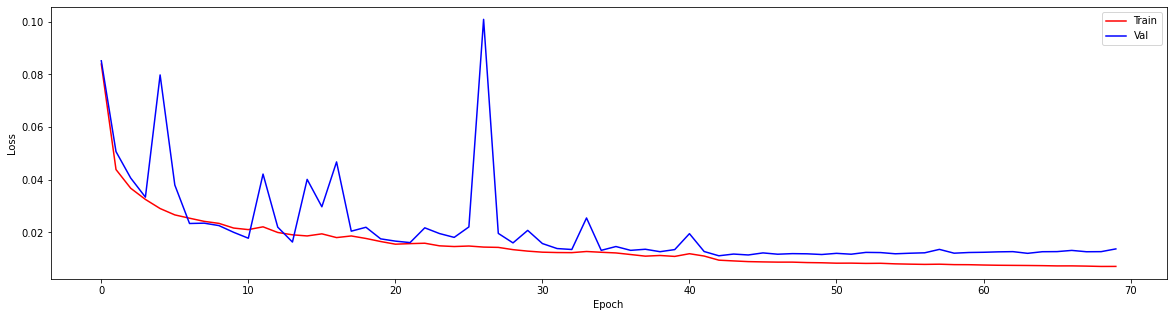

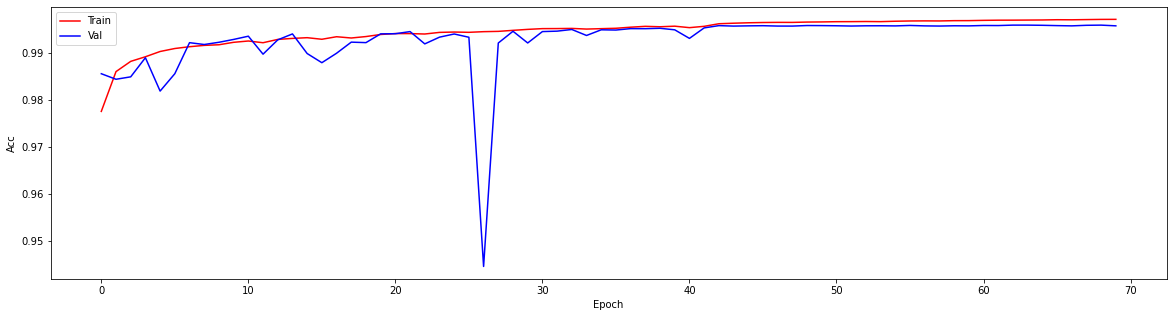

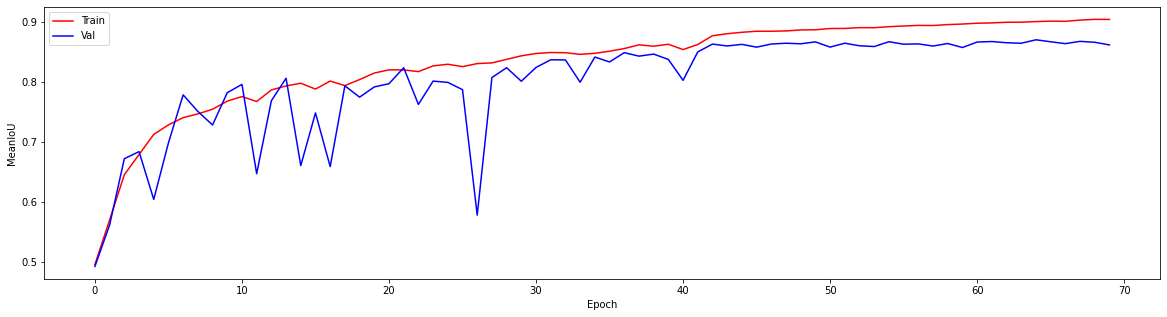

In [21]:
show_history(history, True)

In [29]:
from tensorflow.keras.models import load_model
model = load_model('unet.h5', custom_objects = {'mean_iou': m.mean_iou})

IoU for class1 is: 0.9990781710914455
IoU for class2 is: 0.8818897637795275


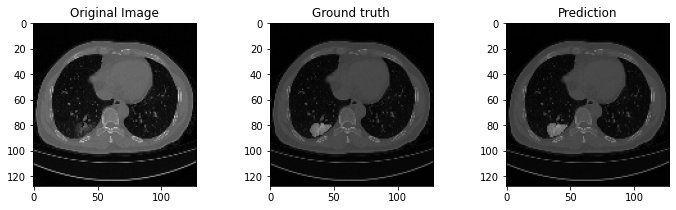

In [34]:
show_example(*all_train_filenames[3], model, encode, (128,128), 'gray', func)